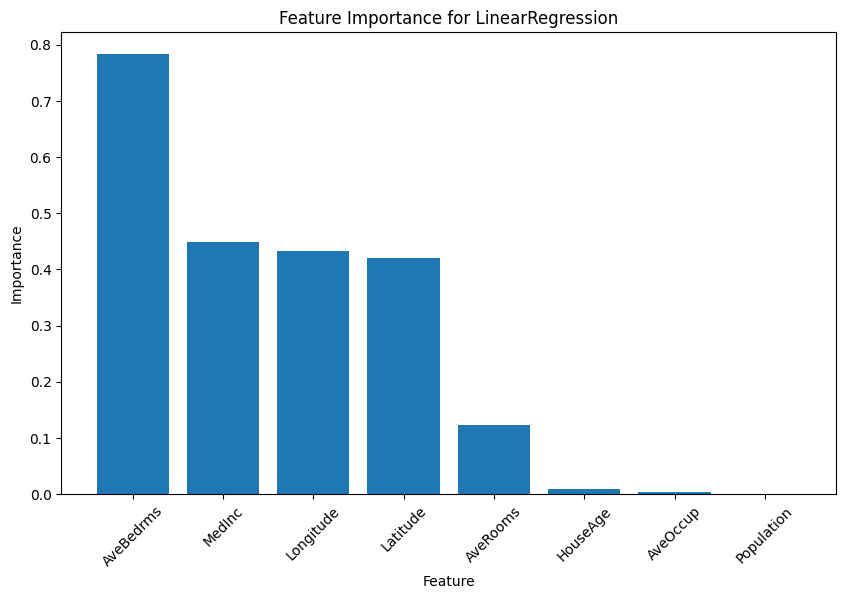

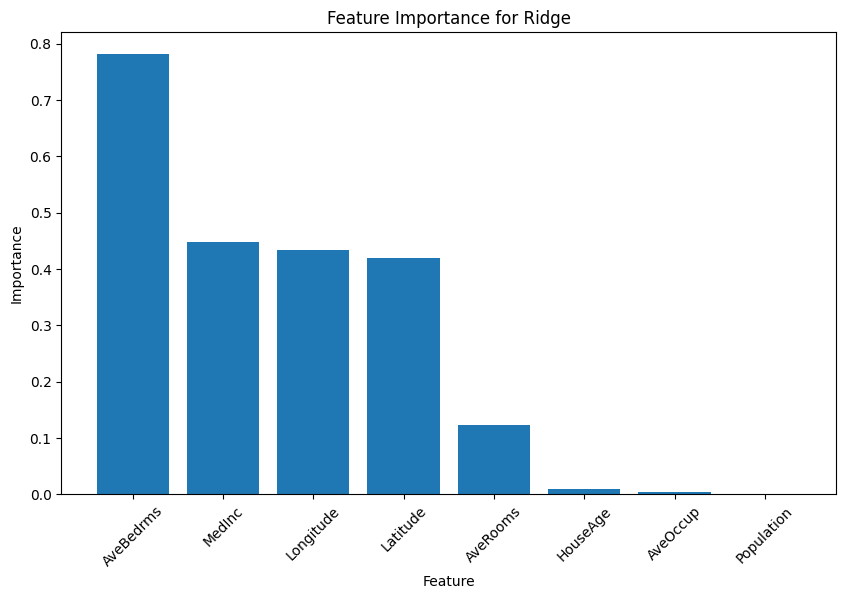

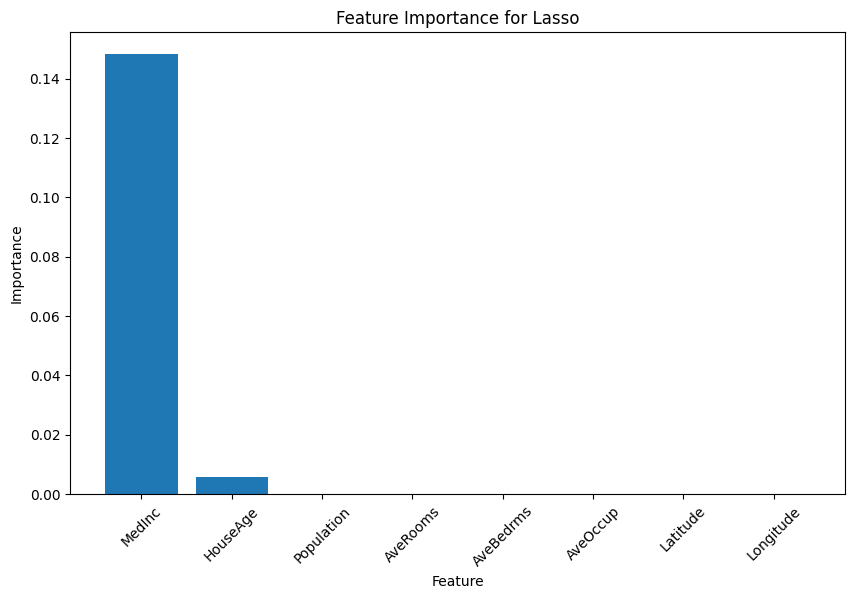

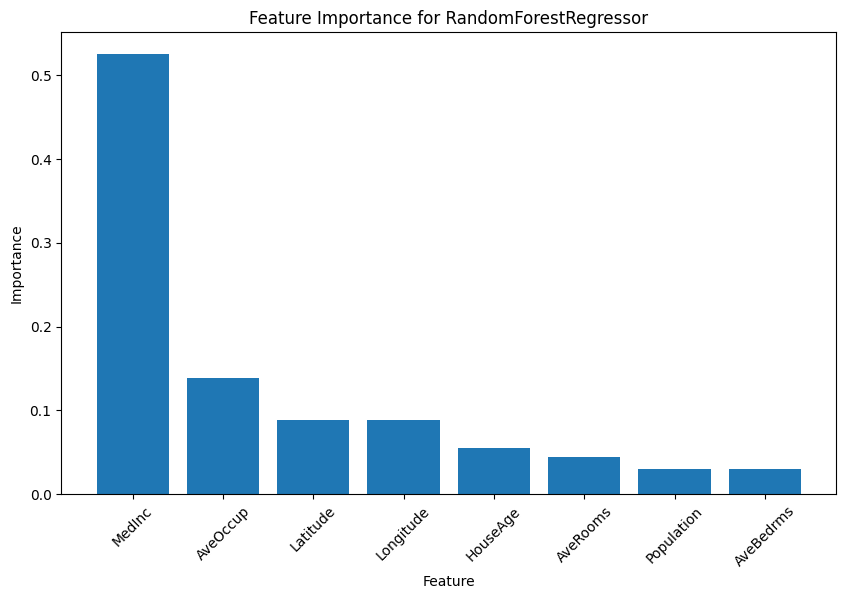

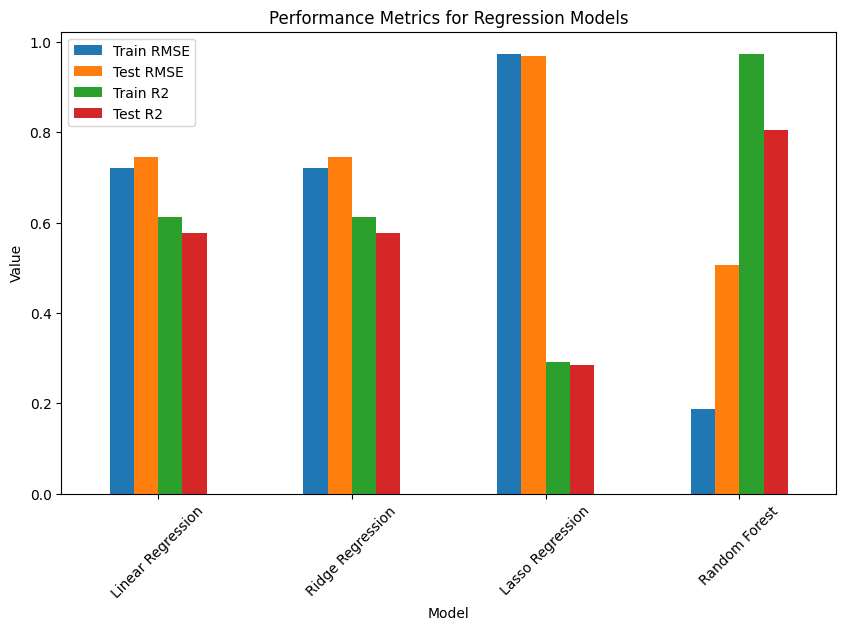

Metrics for Linear Regression
Train RMSE: 0.7196757085831575
Test RMSE: 0.7455813830127761
Train R2: 0.6125511913966952
Test R2: 0.5757877060324511

Metrics for Random Forest
Train RMSE: 0.18795619089802199
Test RMSE: 0.5053399773665033
Train R2: 0.9735726320302575
Test R2: 0.8051230593157366

Best parameters for Ridge: {'alpha': 10.0}
Best parameters for Lasso: {'alpha': 0.001}
Cross-validation scores for Ridge: [0.48358432 0.6228859  0.64621003 0.54379572 0.49445256]
Cross-validation scores for Lasso: [0.48188716 0.62394333 0.64614143 0.54550935 0.49389838]


<Figure size 1000x600 with 0 Axes>

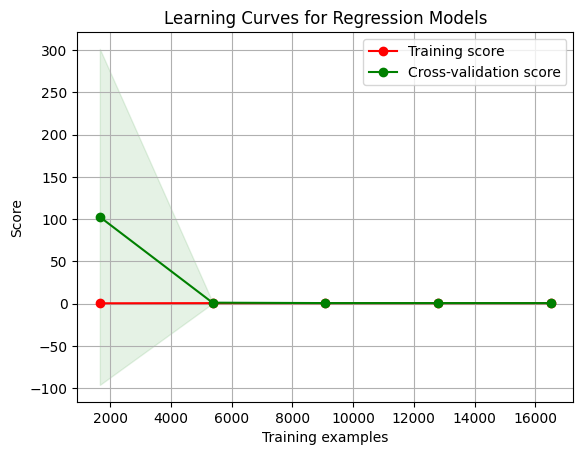

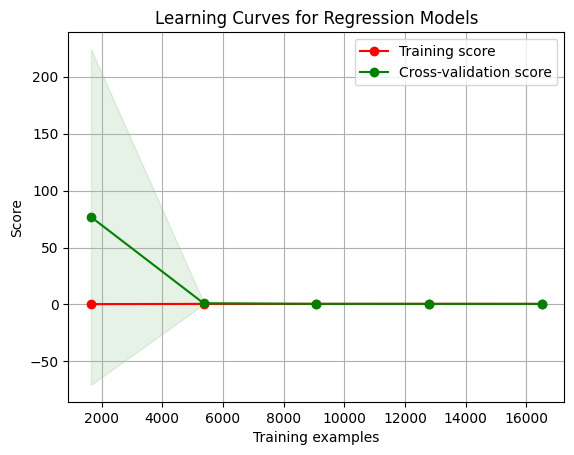

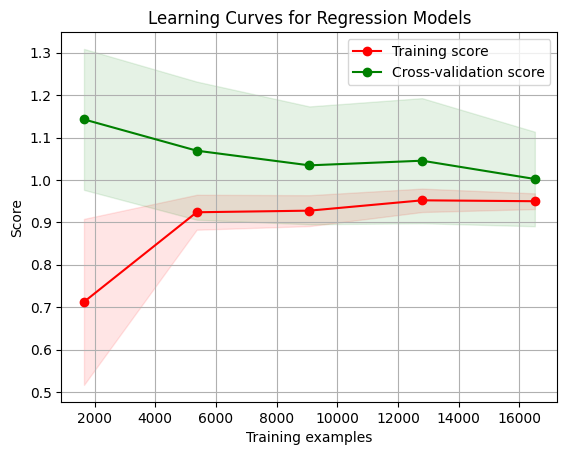

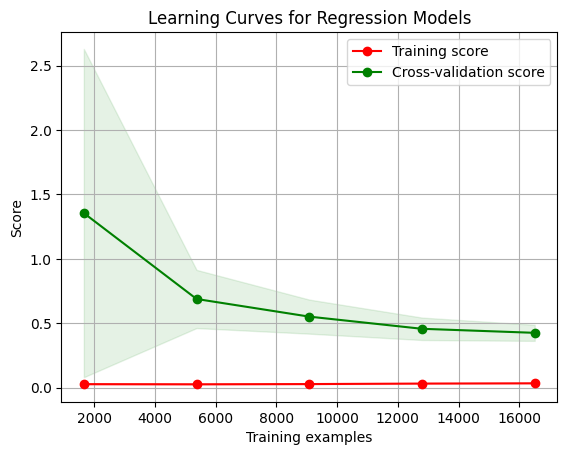

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel

# Загрузка датасета
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# Разбиение данных на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание датафрейма для хранения метрик
metrics_df = pd.DataFrame(index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest'], 
                          columns=['Train RMSE', 'Test RMSE', 'Train R2', 'Test R2'])

# Обучение моделей и оценка метрик
models = [LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(random_state=42)]
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    metrics_df.iloc[i] = [train_rmse, test_rmse, train_r2, test_r2]

    # Визуализация значимости признаков
    if hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_)
    else:
        feature_importance = model.feature_importances_
    feature_names = data.feature_names
    feature_importance_df = pd.DataFrame(data=feature_importance, index=feature_names, columns=['Importance'])
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df.index, feature_importance_df['Importance'])
    plt.title('Feature Importance for ' + type(model).__name__)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.xticks(rotation=45)
    plt.show()

# Визуализация метрик
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics for Regression Models')
plt.ylabel('Value')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

# Вывод метрик для линейной регрессии и случайного леса
for i, model_name in enumerate(['Linear Regression', 'Random Forest']):
    print("Metrics for", model_name)
    print("Train RMSE:", metrics_df.loc[model_name, 'Train RMSE'])
    print("Test RMSE:", metrics_df.loc[model_name, 'Test RMSE'])
    print("Train R2:", metrics_df.loc[model_name, 'Train R2'])
    print("Test R2:", metrics_df.loc[model_name, 'Test R2'])
    print()

# Подбор оптимальных параметров для моделей
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error')

ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)

print("Best parameters for Ridge:", ridge_grid.best_params_)
print("Best parameters for Lasso:", lasso_grid.best_params_)

# Оценка качества работы моделей на основе кросс-валидации
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(Ridge(alpha=ridge_grid.best_params_['alpha']), X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores for Ridge:", -cv_scores)

cv_scores = cross_val_score(Lasso(alpha=lasso_grid.best_params_['alpha']), X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores for Lasso:", -cv_scores)

# Построение кривых обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plt.figure(figsize=(10, 6))
title = "Learning Curves for Regression Models"
for model in models:
    plot_learning_curve(model, title, X, y, cv=5)
plt.show()

Accuracy: 0.8934108527131783
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2077
           1       0.90      0.89      0.89      2051

    accuracy                           0.89      4128
   macro avg       0.89      0.89      0.89      4128
weighted avg       0.89      0.89      0.89      4128



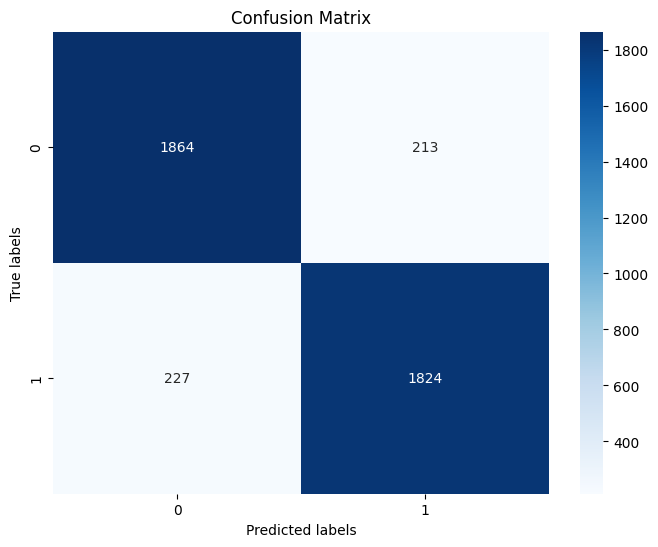

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# Преобразование задачи регрессии в задачу классификации
y_class = (y > np.median(y)).astype(int)  # бинарная классификация - выше или ниже медианного значения

# Разбиение данных на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Обучение модели случайного леса
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = rf_classifier.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вывод отчета о классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Создание тепловой карты матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
